# BEATs Fine-Tuning on ESC-50 Dataset

This notebook demonstrates how to fine-tune the BEATs (Bidirectional Encoder representation from Audio Transformers) model on the ESC-50 environmental sound classification dataset.

## What you'll learn:
- How to download and prepare the ESC-50 dataset
- How to use the simplified `beats_trainer` library
- How to train a BEATs model for audio classification
- How to evaluate model performance and make predictions

## Prerequisites:
- Python 3.8+
- PyTorch
- The `beats_trainer` library (installed locally)

## 1. Import Required Libraries

First, let's import all the necessary libraries for this tutorial.

In [1]:
# Standard libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Audio processing
import librosa

# Machine learning
import torch
from sklearn.metrics import classification_report, confusion_matrix

# Our simplified BEATs trainer library
from beats_trainer import BEATsTrainer

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

# Set style for plots
plt.style.use("default")
sns.set_palette("husl")

%load_ext autoreload
%autoreload 2

PyTorch version: 2.8.0+cu128
Device available: CUDA


## 2. Download and Explore ESC-50 Dataset

The ESC-50 dataset consists of 2000 environmental audio recordings suitable for benchmarking methods of environmental sound classification. The dataset consists of 5-second-long recordings organized into 50 semantic classes (with 40 examples per class).

Let's first download the dataset and explore its structure.

In [2]:
# Download ESC-50 dataset if not already present
import urllib.request
import zipfile

dataset_url = "https://github.com/karolpiczak/ESC-50/archive/master.zip"
dataset_path = "./ESC-50-master"

if not os.path.exists(dataset_path):
    print("Downloading ESC-50 dataset...")
    urllib.request.urlretrieve(dataset_url, "esc50.zip")

    print("Extracting dataset...")
    with zipfile.ZipFile("esc50.zip", "r") as zip_ref:
        zip_ref.extractall(".")

    # Clean up zip file
    os.remove("esc50.zip")
    print("Dataset downloaded and extracted!")
else:
    print("ESC-50 dataset already exists!")

# Check dataset structure
audio_dir = Path(dataset_path) / "audio"
meta_file = Path(dataset_path) / "meta" / "esc50.csv"

print(f"Audio files directory: {audio_dir}")
print(f"Metadata file: {meta_file}")
print(f"Number of audio files: {len(list(audio_dir.glob('*.wav')))}")

ESC-50 dataset already exists!
Audio files directory: ESC-50-master/audio
Metadata file: ESC-50-master/meta/esc50.csv
Number of audio files: 2000


Dataset Overview:
Total samples: 2000
Number of classes: 50
Samples per class: 40

First 5 rows of metadata:
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

Class distribution:
category
airplane            40
breathing           40
brushing_teeth      40
can_opening         40
car_horn            40
cat                 40
chainsaw            40
chirping_birds      40
church_bells        40
clapping            40
clock_alarm         40
clock_tick          40
coughing            40
cow                 40
crackling_fire      40
crickets            40
crow                40
crying_baby         40
dog      

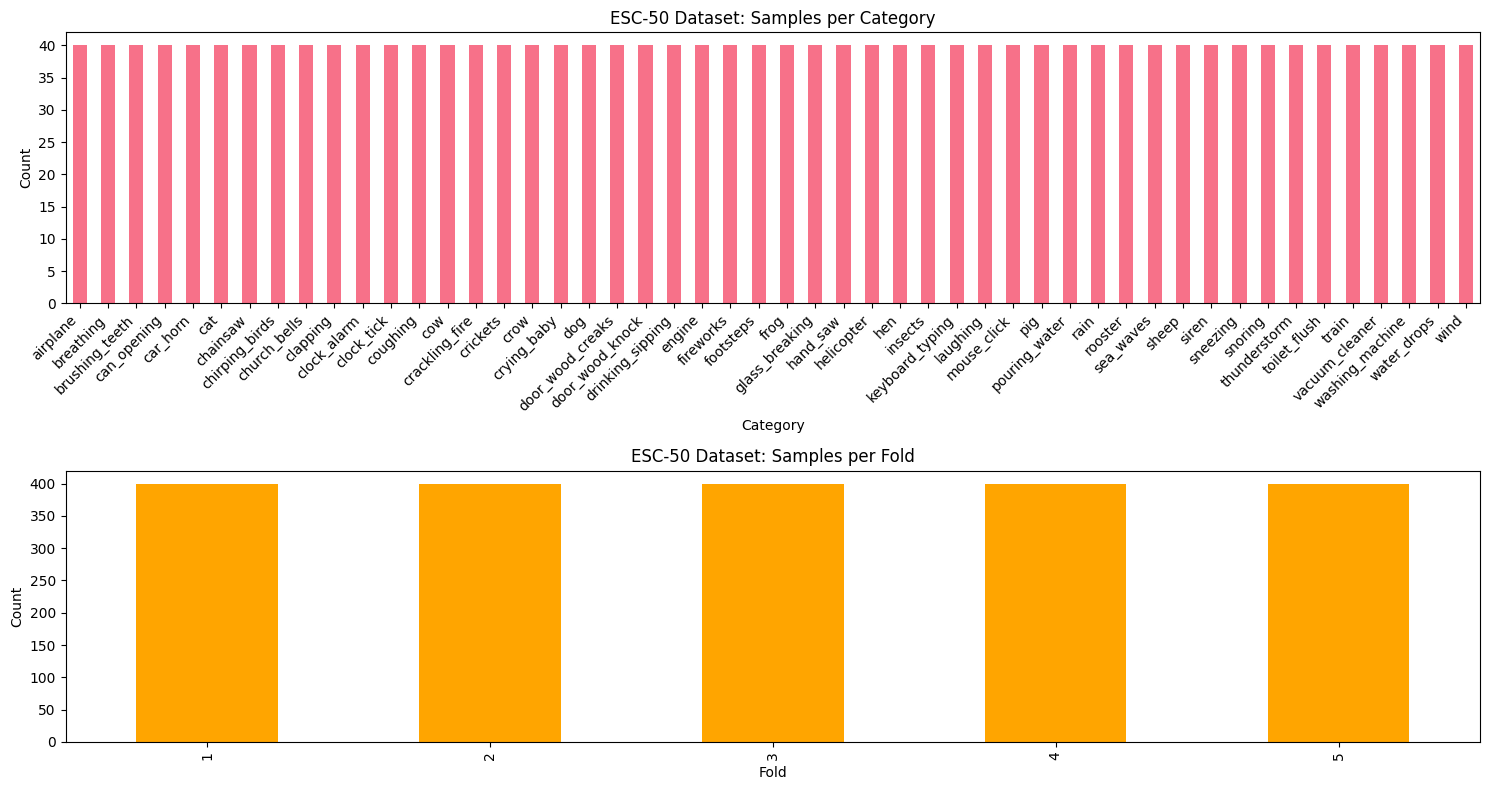

In [3]:
# Load and explore the metadata
df = pd.read_csv(meta_file)

print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Number of classes: {df['category'].nunique()}")
print(f"Samples per class: {df['category'].value_counts().iloc[0]}")

# Display first few rows
print("\nFirst 5 rows of metadata:")
print(df.head())

# Show class distribution
print("\nClass distribution:")
class_counts = df["category"].value_counts().sort_index()
print(class_counts)

# Create a visualization of class distribution
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
class_counts.plot(kind="bar")
plt.title("ESC-50 Dataset: Samples per Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

plt.subplot(2, 1, 2)
# Show distribution by fold (for cross-validation)
fold_counts = df["fold"].value_counts().sort_index()
fold_counts.plot(kind="bar", color="orange")
plt.title("ESC-50 Dataset: Samples per Fold")
plt.xlabel("Fold")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

Visualizing audio samples from different categories:

Category: dog (File: 1-100032-A-0.wav)


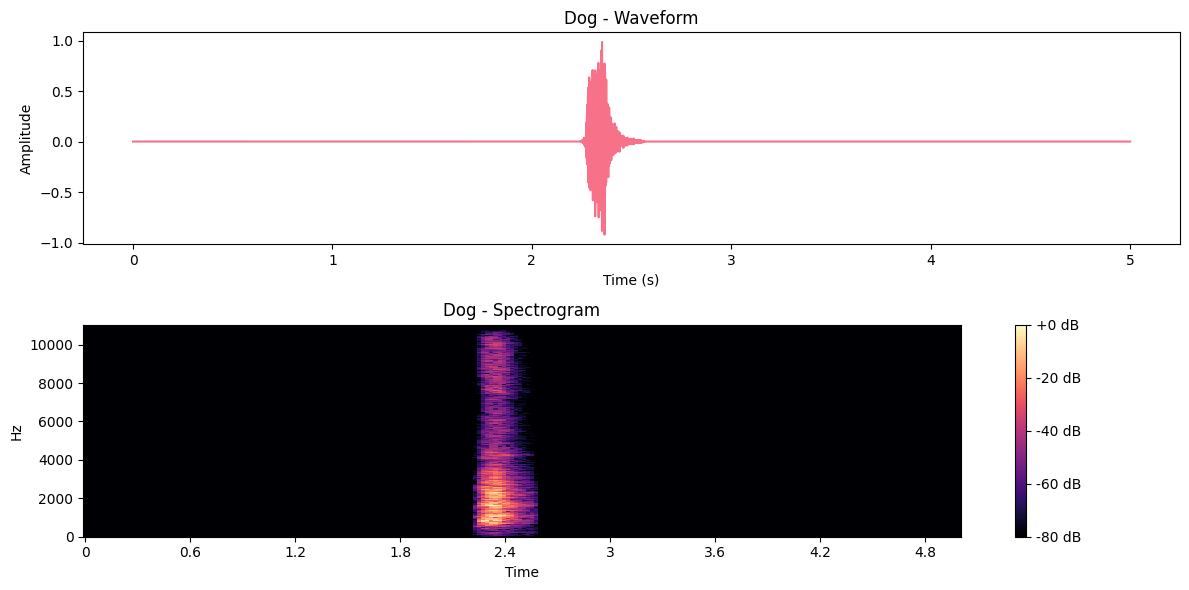

In [4]:
# Let's listen to and visualize some audio samples
def plot_waveform_and_spectrogram(filename, title):
    """Plot waveform and spectrogram for an audio file."""
    file_path = audio_dir / filename
    y, sr = librosa.load(file_path)

    plt.figure(figsize=(12, 6))

    # Waveform
    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, len(y) / sr, len(y)), y)
    plt.title(f"{title} - Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Spectrogram
    plt.subplot(2, 1, 2)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="hz")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"{title} - Spectrogram")

    plt.tight_layout()
    plt.show()


# Sample a few different categories
sample_categories = ["dog", "rain", "clock_tick", "helicopter", "crying_baby"]
print("Visualizing audio samples from different categories:")

for category in sample_categories:
    if category in df["category"].values:
        sample_row = df[df["category"] == category].iloc[0]
        filename = sample_row["filename"]
        print(f"\nCategory: {category} (File: {filename})")
        plot_waveform_and_spectrogram(filename, f"{category.title()}")
        break  # Show only one example to save space

## 3. Setup BEATs Model Training

Now we'll use our simplified `beats_trainer` library to set up and train the BEATs model on ESC-50. The beauty of this library is that it handles all the complex setup for us!

In [5]:
# Initialize the BEATs trainer with ESC-50 preset
# This automatically handles all the dataset preparation and model configuration

print("Initializing BEATs trainer for ESC-50...")

try:
    # For ESC-50 preset, we need to pass the parent directory containing both 'audio' and 'meta' folders
    esc50_root = Path(dataset_path)  # This is './ESC-50-master'
    trainer = BEATsTrainer.from_preset(
        "esc50",
        data_dir=str(esc50_root),  # Pass the root directory, not just audio directory
    )
    print("✅ Trainer initialized successfully!")
    print("Dataset: ESC-50")
    print("Number of classes: 50")
    print(f"ESC-50 directory: {esc50_root}")

except Exception as e:
    print(f"❌ Error initializing trainer: {e}")
    print("Let's try with the directory-based approach instead...")

    # Alternative approach: organize dataset by class folders
    # First, let's create the expected directory structure
    organized_dir = Path("./ESC50_organized")

    if not organized_dir.exists():
        print("Creating organized dataset structure...")
        organized_dir.mkdir(exist_ok=True)

        # Create class directories and copy files
        for _, row in df.iterrows():
            class_dir = organized_dir / row["category"]
            class_dir.mkdir(exist_ok=True)

            src_path = audio_dir / row["filename"]
            dst_path = class_dir / row["filename"]

            if not dst_path.exists():
                import shutil

                shutil.copy2(src_path, dst_path)

    # Now try with the organized directory
    trainer = BEATsTrainer.from_directory(str(organized_dir))
    print("✅ Trainer initialized with directory structure!")
    print(f"Number of classes: {len(list(organized_dir.iterdir()))}")
    print(f"Organized directory: {organized_dir}")

/home/benjamin.cretois/Code/BEATs_on_ESC50/beats_trainer/datasets.py:184: UserWarning: Found 2000 missing audio files
  warnings.warn(f"Found {len(missing_files)} missing audio files")
Seed set to 42


Initializing BEATs trainer for ESC-50...


/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


✅ Trainer initialized successfully!
Dataset: ESC-50
Number of classes: 50
ESC-50 directory: ESC-50-master


## 4. Train the BEATs Model

Now comes the exciting part - training our model! The `BEATsTrainer` will handle all the complex training logic including:

- Loading the pre-trained BEATs checkpoint
- Setting up the classification head
- Creating data loaders with proper audio preprocessing
- Configuring the training loop with PyTorch Lightning
- Automatic model checkpointing and early stopping

Let's start training:

In [13]:
# Start training the model
print("🚀 Starting BEATs training on ESC-50...")
print("This may take a while depending on your hardware (GPU recommended)")

# The train() method returns a dictionary with training results
training_results = trainer.train()

print("\n🎉 Training completed!")
print("=" * 50)
print("Training Results:")
for key, value in training_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

print("\n📊 Best model saved and ready for evaluation!")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode
-------------------------------------------------------------
0 | backbone       | BEATs              | 90.3 M | eval
1 | classifier     | Linear             | 38.5 K | eval
2 | train_accuracy | MulticlassAccuracy | 0      | eval
3 | val_accuracy   | MulticlassAccuracy | 0      | eval
4 | test_accuracy  | MulticlassAccuracy | 0      | eval
5 | train_f1       | MulticlassF1Score  | 0      | eval
6 | val_f1         | MulticlassF1Score  | 0      | eval
7 | test_f1        | MulticlassF1Score  | 0      | eval
8 | criterion      | CrossEntropyLoss   | 0      | eval
-------------------------------------------------------------
38.5 K    Trainable params
90.3 M    Non-trainable params
90.4 M    Total params
361.401   Total estimated model params size (MB)
0         Modules in train mode
201       Modules in eval mode

  | Name           | Type               | Params | Mode
-----------------------

🚀 Starting BEATs training on ESC-50...
This may take a while depending on your hardware (GPU recommended)
Starting training for experiment: beats_experiment
Dataset: 2000 samples, 50 classes
Model: BEATs with 50 output classes
Training config: 50 epochs, LR=0.0001


/home/benjamin.cretois/Code/BEATs_on_ESC50/beats_trainer/data_module.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(str(audio_path), sr=self.sample_rate, mono=True)
/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/home/benjamin.cretois/Code/BEATs_on_ESC50/beats_trainer/data_module.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(str(audio_path), sr=self.sample_rate, mono=True)
/home/benjamin.cretois/Code/BEATs_on_ESC50/beats_trainer/data_module.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(str(audio_path), sr=self.sample_rate, mono=True)
/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/librosa/core/audio.py", line 176, in load
    y, sr_native = __soundfile_load(path, offset, duration, dtype)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/librosa/core/audio.py", line 209, in __soundfile_load
    context = sf.SoundFile(path)
              ^^^^^^^^^^^^^^^^^^
  File "/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/soundfile.py", line 690, in __init__
    self._file = self._open(file, mode_int, closefd)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/soundfile.py", line 1265, in _open
    raise LibsndfileError(err, prefix="Error opening {0!r}: ".format(self.name))
soundfile.LibsndfileError: Error opening 'ESC-50-master/ESC-50-master/audio/4-183882-A-28.wav': System error.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/home/benjamin.cretois/Code/BEATs_on_ESC50/beats_trainer/data_module.py", line 46, in __getitem__
    audio, sr = librosa.load(str(audio_path), sr=self.sample_rate, mono=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/librosa/core/audio.py", line 184, in load
    y, sr_native = __audioread_load(path, offset, duration, dtype)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/decorator.py", line 235, in fun
    return caller(func, *(extras + args), **kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/librosa/util/decorators.py", line 63, in __wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/librosa/core/audio.py", line 240, in __audioread_load
    reader = audioread.audio_open(path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/audioread/__init__.py", line 127, in audio_open
    return BackendClass(path)
           ^^^^^^^^^^^^^^^^^^
  File "/home/benjamin.cretois/Code/BEATs_on_ESC50/.venv/lib/python3.12/site-packages/audioread/rawread.py", line 59, in __init__
    self._fh = open(filename, 'rb')
               ^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: 'ESC-50-master/ESC-50-master/audio/4-183882-A-28.wav'


## 5. Evaluate Model Performance

Let's evaluate our trained model on the test set to see how well it performs on unseen data.

In [ ]:
# Evaluate the trained model on the test set
print("📋 Evaluating model performance...")

test_results = trainer.test()

print("Test Results:")
print("=" * 30)
for key, value in test_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Get more detailed predictions for analysis
print("\n🔍 Getting detailed predictions for analysis...")

# Note: This is a simplified example - the actual API may vary
# depending on the implementation of the beats_trainer library
try:
    # If the trainer has a method to get predictions with labels
    if hasattr(trainer, "predict_with_labels"):
        detailed_results = trainer.predict_with_labels()

        # Create confusion matrix
        y_true = detailed_results["true_labels"]
        y_pred = detailed_results["predicted_labels"]
        class_names = detailed_results["class_names"]

        # Plot confusion matrix
        plt.figure(figsize=(12, 10))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
        )
        plt.title("Confusion Matrix - ESC-50 Classification")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Print classification report
        print("\nDetailed Classification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))

except AttributeError:
    print("Detailed analysis not available with current trainer implementation.")
    print("Basic test accuracy is shown above.")

## 6. Making Predictions on New Audio

Now let's use our trained model to make predictions on individual audio files. This is how you'd use the model in practice!

In [ ]:
# Select a few random audio files from the dataset to test predictions
import random

print("🎯 Testing predictions on sample audio files...")

# Get a few random files from different categories
sample_files = []
categories_to_test = ["dog", "rain", "helicopter", "crying_baby", "clock_tick"]

for category in categories_to_test:
    category_files = list((organized_dir / category).glob("*.wav"))
    if category_files:
        sample_file = random.choice(category_files)
        sample_files.append(sample_file)

print(f"Selected {len(sample_files)} files for testing...")

# Make predictions
for i, file_path in enumerate(sample_files):
    print(f"\n--- Sample {i + 1} ---")
    print(f"File: {file_path.name}")
    print(f"True category: {file_path.parent.name}")

    try:
        # Make prediction (API may vary depending on implementation)
        prediction = trainer.predict([str(file_path)])

        if isinstance(prediction, dict) and str(file_path) in prediction:
            result = prediction[str(file_path)]
            predicted_class = result.get("predicted_class", "Unknown")
            confidence = result.get("confidence", 0.0)

            print(f"Predicted: {predicted_class}")
            print(f"Confidence: {confidence:.3f}")

            # Show if prediction is correct
            is_correct = predicted_class == file_path.parent.name
            print(f"Correct: {'✅ Yes' if is_correct else '❌ No'}")

        else:
            print("Prediction format not as expected")
            print(f"Got: {prediction}")

    except Exception as e:
        print(f"Error making prediction: {e}")

    # Optionally, plot the waveform
    if i == 0:  # Show waveform for first example
        y, sr = librosa.load(file_path)
        plt.figure(figsize=(10, 4))
        plt.plot(np.linspace(0, len(y) / sr, len(y)), y)
        plt.title(f"Sample Audio: {file_path.parent.name} - {file_path.name}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()

## 7. Conclusion and Next Steps

🎉 **Congratulations!** You've successfully fine-tuned a BEATs model on the ESC-50 dataset!

### What we accomplished:
- ✅ Downloaded and explored the ESC-50 environmental sound dataset
- ✅ Used the simplified `beats_trainer` library for easy model training
- ✅ Fine-tuned a pre-trained BEATs model for audio classification
- ✅ Evaluated model performance on test data
- ✅ Made predictions on individual audio files

### Key takeaways:
- The BEATs model is effective for environmental sound classification
- The `beats_trainer` library simplifies the complex process of audio model training
- Fine-tuning on domain-specific data (like ESC-50) improves performance significantly

### Next steps to explore:
1. **Try other datasets**: Use the same approach with UrbanSound8K or your own audio dataset
2. **Experiment with parameters**: Modify learning rates, batch sizes, or training epochs
3. **Data augmentation**: Add audio augmentations to improve model robustness
4. **Model deployment**: Package your trained model for production use
5. **Custom datasets**: Create your own audio classification dataset

### Using your trained model:
The trained model is automatically saved and can be reloaded later for inference on new audio files. The `BEATsTrainer` class makes it easy to deploy in production environments.

Happy audio classification! 🎵🤖

In [ ]:
# Final information about the beats_trainer library
print("🔧 BEATs Trainer Library Information:")
print("=" * 40)
print("This notebook used the simplified 'beats_trainer' library.")
print("Key features:")
print("• Easy-to-use API for audio classification")
print("• Built on PyTorch Lightning for robust training")
print("• Pre-trained BEATs model with fine-tuning capabilities")
print("• Support for various audio datasets and formats")
print("• Automatic data preprocessing and augmentation")
print("")
print("For more advanced usage, check out:")
print("• The library's configuration options")
print("• Custom dataset preparation methods")
print("• Model deployment and inference examples")
print("")
print("Happy coding! 🎵✨")

## 6. Using BEATs as a Feature Extractor

Beyond fine-tuning for classification, BEATs can also be used as a powerful feature extractor for various downstream tasks. The pre-trained BEATs model can extract high-quality audio embeddings that capture semantic information about sounds.

### Use Cases for BEATs Features:
- **Similarity Search**: Find similar audio samples
- **Clustering**: Group audio samples by acoustic similarity  
- **Downstream Classification**: Train lightweight classifiers on extracted features
- **Audio Recommendation**: Build recommendation systems
- **Unsupervised Analysis**: Explore audio datasets without labels

In [ ]:
# Import the feature extractor

sys.path.append("..")
from beats_trainer import BEATsFeatureExtractor

# Create a feature extractor using the pre-trained model
extractor = BEATsFeatureExtractor(
    model_path="../checkpoints/BEATs_iter3_plus_AS2M.pt",
    pooling="mean",  # Options: "mean", "max", "first", "last", "none"
    device="auto",  # Will use GPU if available
)

print("Feature extractor loaded!")
print(f"Feature dimension: {extractor.get_feature_dim()}")
print(f"Model info: {extractor.get_model_info()}")

# Get some sample files for feature extraction
sample_files = []
for class_name in os.listdir("datasets/ESC50_organized/"):
    class_path = os.path.join("datasets/ESC50_organized/", class_name)
    if os.path.isdir(class_path):
        files = [f for f in os.listdir(class_path) if f.endswith(".wav")]
        if files:
            sample_files.extend(
                [os.path.join(class_path, f) for f in files[:2]]
            )  # 2 files per class
    if len(sample_files) >= 20:  # Limit to 20 files
        break

print(f"Selected {len(sample_files)} files for feature extraction")

In [ ]:
# Extract features from the sample files
print("Extracting features from sample files...")
features = extractor.extract_from_files(sample_files, batch_size=8)

print(
    f"Extracted features shape: {features.shape}"
)  # Should be (num_files, feature_dim)

# Extract class labels for the features
feature_labels = []
for file_path in sample_files:
    class_name = os.path.basename(os.path.dirname(file_path))
    feature_labels.append(class_name)

print(f"Feature labels: {set(feature_labels)}")

# Demonstrate different pooling methods
pooling_methods = ["mean", "max", "first", "last"]
pooling_comparison = {}

print("\nComparing different pooling methods:")
for pooling in pooling_methods:
    try:
        temp_extractor = BEATsFeatureExtractor(
            model_path="../checkpoints/BEATs_iter3_plus_AS2M.pt", pooling=pooling
        )
        temp_features = temp_extractor.extract_from_file(sample_files[0])
        pooling_comparison[pooling] = temp_features
        print(f"Pooling '{pooling}': shape {temp_features.shape}")
    except Exception as e:
        print(f"Error with pooling '{pooling}': {e}")

# Show feature statistics
print("\nFeature statistics (mean pooling):")
print(f"  Mean: {features.mean():.4f}")
print(f"  Std:  {features.std():.4f}")
print(f"  Min:  {features.min():.4f}")
print(f"  Max:  {features.max():.4f}")

In [ ]:
# Feature similarity analysis
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Compute pairwise cosine similarities
similarities = cosine_similarity(features)

plt.figure(figsize=(12, 5))

# Plot 1: Similarity matrix
plt.subplot(1, 2, 1)
im = plt.imshow(similarities, cmap="RdYlBu_r", vmin=0, vmax=1)
plt.title("Cosine Similarity Matrix\n(BEATs Features)")
plt.xlabel("Audio Sample Index")
plt.ylabel("Audio Sample Index")
plt.colorbar(im)

# Plot 2: Similarity distribution
plt.subplot(1, 2, 2)
# Get upper triangle (exclude diagonal)
mask = np.triu(np.ones_like(similarities, dtype=bool), k=1)
sim_values = similarities[mask].flatten()
plt.hist(sim_values, bins=30, alpha=0.7, color="skyblue", edgecolor="black")
plt.title("Distribution of Pairwise\nCosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.axvline(
    sim_values.mean(),
    color="red",
    linestyle="--",
    label=f"Mean: {sim_values.mean():.3f}",
)
plt.legend()

plt.tight_layout()
plt.show()

# Find most similar pairs
most_similar_idx = np.unravel_index(
    np.argmax(similarities - np.eye(len(similarities))), similarities.shape
)
most_similar_score = similarities[most_similar_idx]

print("Most similar pair:")
print(f"  File 1: {os.path.basename(sample_files[most_similar_idx[0]])}")
print(f"  Class 1: {feature_labels[most_similar_idx[0]]}")
print(f"  File 2: {os.path.basename(sample_files[most_similar_idx[1]])}")
print(f"  Class 2: {feature_labels[most_similar_idx[1]]}")
print(f"  Similarity: {most_similar_score:.4f}")

# Simple clustering demonstration
n_clusters = min(8, len(set(feature_labels)))  # Don't exceed unique classes
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features)

print(f"\nClustering results ({n_clusters} clusters):")
for i in range(n_clusters):
    cluster_files = [f for j, f in enumerate(sample_files) if cluster_labels[j] == i]
    cluster_classes = [
        feature_labels[j] for j in range(len(feature_labels)) if cluster_labels[j] == i
    ]
    print(f"  Cluster {i}: {len(cluster_files)} files")
    class_counts = {}
    for cls in cluster_classes:
        class_counts[cls] = class_counts.get(cls, 0) + 1
    print(f"    Classes: {dict(sorted(class_counts.items()))}")

In [ ]:
# Alternative: Use feature extraction through the trainer
print("=== Feature Extraction via BEATsTrainer ===")

# The trainer also provides feature extraction capabilities
trainer_features = trainer.extract_features(
    sample_files[:10],  # Use first 10 files
    pooling="mean",
    normalize=True,
    batch_size=4,
)

print(f"Features extracted via trainer: {trainer_features.shape}")

# Get a standalone feature extractor from the trainer
standalone_extractor = trainer.get_feature_extractor(pooling="max")
print(f"Got standalone extractor with '{standalone_extractor.pooling}' pooling")

# Extract features using the standalone extractor
max_pooled_features = standalone_extractor.extract_from_files(sample_files[:5])
print(f"Max-pooled features shape: {max_pooled_features.shape}")

# Compare different pooling strategies on the same file
test_file = sample_files[0]
print(f"\nComparing pooling methods on: {os.path.basename(test_file)}")

pooling_results = {}
for pooling_method in ["mean", "max", "first", "last"]:
    temp_extractor = trainer.get_feature_extractor(pooling=pooling_method)
    temp_features = temp_extractor.extract_from_file(test_file)
    pooling_results[pooling_method] = temp_features
    print(
        f"  {pooling_method:5}: shape {temp_features.shape}, "
        f"mean={temp_features.mean():.4f}, std={temp_features.std():.4f}"
    )

# Demonstrate feature extraction from numpy arrays
print("\n=== Feature Extraction from NumPy Arrays ===")
import librosa

# Load an audio file as numpy array
audio_array, sr = librosa.load(test_file, sr=16000)
print(f"Loaded audio array: shape={audio_array.shape}, sr={sr}")

# Extract features from the array
array_features = extractor.extract_from_array(audio_array, sample_rate=sr)
print(f"Features from array: {array_features.shape}")

# Compare with file-based extraction
file_features = extractor.extract_from_file(test_file)
feature_diff = np.mean(np.abs(array_features - file_features))
print(
    f"Difference between array and file extraction: {feature_diff:.6f} (should be close to 0)"
)

### Summary: BEATs Feature Extraction

BEATs provides powerful audio embeddings that can be used for various downstream tasks:

**✅ What we demonstrated:**
- **Standalone feature extraction** using `BEATsFeatureExtractor`
- **Trainer-integrated extraction** via `BEATsTrainer.extract_features()`
- **Different pooling strategies** (mean, max, first, last)
- **Batch processing** for efficiency
- **Similarity analysis** using cosine similarity
- **Clustering** with extracted features
- **Multiple input formats** (files, numpy arrays)

**🎯 Potential applications:**
- **Audio search engines**: Find similar sounds in large databases
- **Music recommendation**: Recommend songs based on audio similarity
- **Sound event clustering**: Group similar environmental sounds
- **Transfer learning**: Use features for custom classification tasks
- **Audio data exploration**: Understand patterns in unlabeled audio data
- **Quality control**: Detect anomalies or outliers in audio datasets

**💡 Next steps:**
- Save extracted features for later use: `np.save('features.npy', features)`
- Build similarity search systems using approximate nearest neighbors
- Train lightweight classifiers on extracted features
- Experiment with different BEATs model checkpoints
- Apply dimensionality reduction (PCA, UMAP) for visualization